Pipeline Visualization

In [2]:
! pip install -r ../requirements.txt

In [3]:
import sys
import os
sys.path.append('C:/Users/Sania Serrao/projects/LULCmapsGen/src')
import requests
import json

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as cl

import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping libraries
import ee #earth engine
import eeconvert as eec
import geemap
import folium


import torch
from torchvision import datasets, models, transforms

from selenium import webdriver

In [4]:
from geodata import get_geodata
from geo_plot import plot_district, plot_sat_img,plot_tiles,plot_crop
from generate_image import generate_image
from export_image import export_image
from generate_tiles import generate_tiles

from utils import load_model
from predict_crop import predict_crop
from color_map import color_map
from visualize_lulc import visualize_lulc
from export_lulc import export_lulc

In [5]:
ee.Authenticate()
ee.Initialize(project="")

In [7]:
geobound = gpd.read_file('C:/Users/Sania Serrao/projects/LULCmapsGen/data/geoboundaryIND_ADM3.geojson')
geobound.head(2)

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Ghograpar (Pt),,7132399B28259355418462,IND,ADM3,"POLYGON ((91.49594 26.54833, 91.49466 26.55303..."
1,Chapar Pt,,7132399B69733852015738,IND,ADM3,"POLYGON ((90.46034 26.35629, 90.45644 26.35788..."


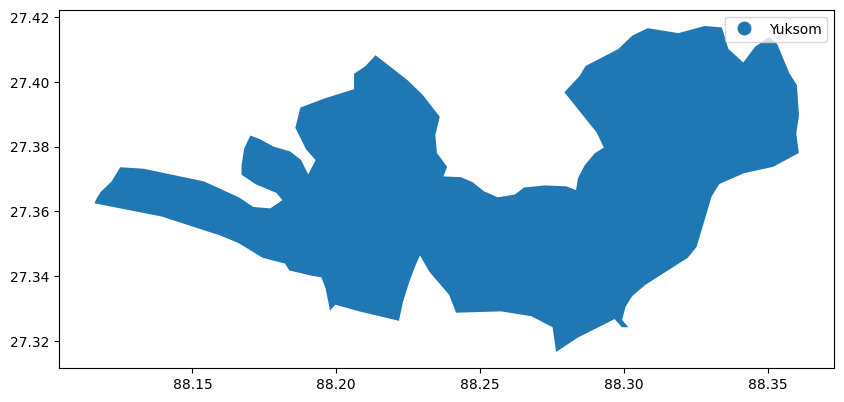

In [37]:
roi='Yuksom'
plot_district(geobound,roi)


In [38]:
region=geobound.loc[geobound.shapeName == roi]
centroid = region.iloc[0].geometry.centroid.coords[0]
region=eec.gdfToFc(region)


image = generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2021-01-01', 
    max_date='2023-12-31',
    cloud_pct=10
)


Map = geemap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image,{},'Sentinel2')
Map.addLayerControl()


In [39]:
Map

Map(center=[27.367437454419886, 88.25829319693794], controls=(WidgetControl(options=['position', 'transparent_…

In [40]:
filename='sentinel2'+'_'+roi
path=export_image(image,filename,region.geometry())

Exporting sentinel2_Yuksom.zip...
Download URL: https://earthengine.googleapis.com/v1/projects/97158930735/thumbnails/d7a0ce23c7f86fc57bbd24e5521fb238-91e4be1b5068c1dd15eabe93a35aac5d:getPixels
ZIP file successfully saved to C:/Users/Sania Serrao/projects/LULCmapsGen/images\sentinel2_Yuksom\sentinel2_Yuksom.zip
RGB image saved to C:/Users/Sania Serrao/projects/LULCmapsGen/images\sentinel2_Yuksom\sentinel2_Yuksom_RGB.tif


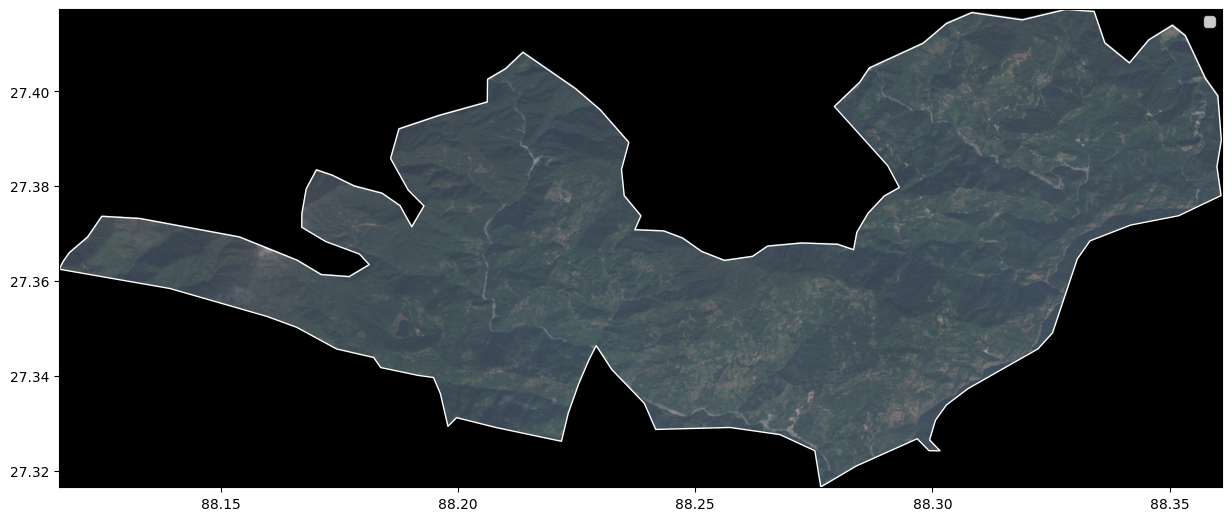

In [41]:
img_path='C:/Users/Sania Serrao/projects/LULCmapsGen/images/sentinel2_Yuksom/sentinel2_Yuksom_RGB.tif'
plot_sat_img(img_path,geobound,roi)

In [ ]:
output_file = os.path.join('C:/Users/Sania Serrao/projects/LULCmapsGen/data', '{}.geojson'.format(roi))
tiles = generate_tiles(img_path, output_file, roi, size=64)


In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = "C:/Users/Sania Serrao/projects/LULCmapsGen/models/best_model.pth"



model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Model file C:/Users/Sania Serrao/projects/LULCmapsGen/models/best_model.pth successfully loaded.


In [49]:
labels = [] # Store predictions
for index in tqdm(range(len(tiles)), total=len(tiles)):
  label = predict_crop(img_path, [tiles.iloc[index]['geometry']], model)
  labels.append(label)
tiles['pred'] = labels


filepath = os.path.join("C:/Users/Sania Serrao/projects/LULCmapsGen/predictions", "{}_preds.geojson".format(roi))
tiles.to_file(filepath, driver="GeoJSON")


     

  0%|          | 0/774 [00:00<?, ?it/s]

In [54]:
pred_tiles=gpd.read_file("C:/Users/Sania Serrao/projects/LULCmapsGen/predictions/Yuksom_preds.geojson")
color_tiles=color_map(pred_tiles)

In [56]:
border=geobound.loc[geobound.shapeName == roi]
map=visualize_lulc(centroid,border,color_tiles)
map

In [57]:
export_lulc('C:/Users/Sania Serrao/projects/LULCmapsGen/maps',roi,map)

TIFF file saved as C:/Users/Sania Serrao/projects/LULCmapsGen/maps\Yuksom\lulc_mapYuksom.tiff
